# Statistical Machine Learning

This kernel will walk you through how to build KNN and tree models, how to tune their hyperparameters.

Most examples and data used in this kernel are referenced from Chapter 6 "Statistical Machine Learning" in "Practial Statistics for Data Scientists".

In [1]:
import math
import os
import random
from pathlib import Path
from collections import defaultdict
from itertools import product


import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from dmba import plotDecisionTree, textDecisionTree

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

## K-Nearest Neighbors
- K-Nearest Neighbors (KNN) classifies a record by assigning it to the class that similar records belong to.
- Similarity (distance) is determined by __Euclidian distance__ or other related metrics.
- The number of nearest neighbors to compare a record to, $K$, is determined by how well the algorithm performs on training data, using different values for $K$.
- Typically, the predictor variables are standardized so that __variables of large scale do not dominate the distance metric__.
- KNN is often used as a first stage in predictive modeling, and the predicted value is added back into the data as a predictor for second-stage (non-KNN) modeling.

The idea behind KNN is very simple. For each record to be classified or predicted:
1. Find K records that have similar features (i.e., similar predictor values).
2. For classification, find out what the majority class is among those similar records and assign that class to the new record.
3. For prediction, find the average among those similar records, and predict that average for the new record.

KNN is one of the simpler prediction/classification techniques: there is no model to be fit. This doesn't mean that using KNN is an automatic procedure. The prediction results depend on how the features are scaled, how similarity is measured, and how big K is set. Also, all predictions must be in numeric form.

__Example:Predicting Loan Default__
Consider a very simple model with just two predictor variables with a small set of 200 loans.

In [2]:
loan200 = pd.read_csv('data/loan200.csv')
 
predictors = ['payment_inc_ratio', 'dti']
outcome = 'outcome'


newloan = loan200.loc[0:0, predictors]
X = loan200.loc[1:, predictors]
y = loan200.loc[1:, outcome]

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y)
print(knn.predict(newloan))
print(knn.predict_proba(newloan))

['paid off']
[[0.45 0.55]]


The table below gives a visual display of this example. The new loan to be predicted is the cross in the middle.

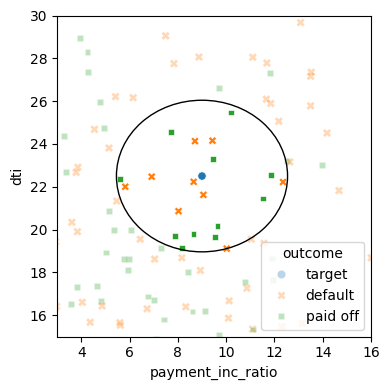

In [3]:
nbrs = knn.kneighbors(newloan)
maxDistance = np.max(nbrs[0][0])

fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(x='payment_inc_ratio', y='dti', style='outcome', 
                hue='outcome', data=loan200, alpha=0.3, ax=ax)
sns.scatterplot(x='payment_inc_ratio', y='dti', style='outcome', 
                hue='outcome', 
                data=pd.concat([loan200.loc[0:0, :], loan200.loc[nbrs[1][0] + 1,:]]), 
                ax=ax, legend=False)
ellipse = Ellipse(xy=newloan.values[0], 
                  width=2 * maxDistance, height=2 * maxDistance,
                  edgecolor='black', fc='None', lw=1)
ax.add_patch(ellipse)
ax.set_xlim(3, 16)
ax.set_ylim(15, 30)

plt.tight_layout()
plt.show()

### Distance Metrics
Similarity (nearness) is determined using a distance metric, which is a function that measures how far two records $(x_1, x_2,...,x_p)$ and $(u_1, u_2,...,u_p)$ are from one another. The most popular distance metric between two vectors is __Euclidean distance__. To measure the Euclidean distance between two vectors, subtract one from the other, square the differences, adn take the square root:

$$
\sqrt{(x_1 - u_1)^2 + (x_2 - u_2)^2 + ... + (x_p - u_p)^2}
$$

Another common distance metric for numeric data is __Manhattan distance__.

$$
|x_1 - u_1| + |x_2 - u_2| + ... + |x_p - u_p|
$$

Euclidean distance corresponds to the straight-line distance between two points. Manhattan distance is the distance between two points traversed in a single direction at a time. For this reason, Manhattan distance is a useful approximation if similarity is defined as point-to-point travel time.

In measuring distance between two vectors, variables (features) that are measured with comparatively large scale will dominate the measure. We address this problem by standardizing the data.

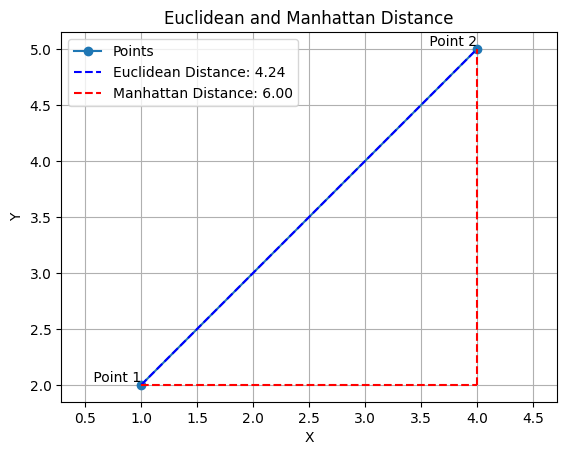

In [4]:
import matplotlib.pyplot as plt

# Define two points in 2D space
point1 = [1, 2]
point2 = [4, 5]

# Plot the points
plt.plot([point1[0], point2[0]], [point1[1], point2[1]], marker='o', label='Points')
plt.text(point1[0], point1[1], ' Point 1', verticalalignment='bottom', horizontalalignment='right')
plt.text(point2[0], point2[1], ' Point 2', verticalalignment='bottom', horizontalalignment='right')

# Plot the Euclidean distance (straight-line distance)
euclidean_distance = ((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)**0.5
plt.plot([point1[0], point2[0]], [point1[1], point2[1]], linestyle='--', label=f'Euclidean Distance: {euclidean_distance:.2f}', color='blue')

# Plot the Manhattan distance (distance traversed in a single direction at a time)
manhattan_distance = abs(point2[0] - point1[0]) + abs(point2[1] - point1[1])
plt.plot([point1[0], point2[0]], [point1[1], point1[1]], linestyle='--', label=f'Manhattan Distance: {manhattan_distance:.2f}', color='red')
plt.plot([point2[0], point2[0]], [point1[1], point2[1]], linestyle='--', color='red')

# Set plot attributes
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Euclidean and Manhattan Distance')
plt.legend()
plt.grid(True)

# Show plot
plt.axis('equal')
plt.show()


### Standardization (Normalization, z-Scores)
In measurement, we are often not so much interested in "how much" but in "how different from the average." __Standardization__, also called normalization, puts all variables on similar scales by subtracting the mean and dividing by the standard deviation; in this way, we ensure that a variable does not overly influence a model simply due to the scale of its original measurement:

$$
z = \frac{x-\bar{x}}{s}
$$

The result of this transformation is commonly referred to as a z-score. Measurements are then stated in terms of "standard deviations away from the mean." For KNN and a few other procedures (e.g., principal components analysis and clustering), it is essential to consider standardizing the data prior to applying the procedure. To illustrate this idea, KNN is applied to the loan data using 4 predictors.

In [5]:
loan_data = pd.read_csv('data/loan_data.csv.gz')
loan_data = loan_data.drop(columns=['Unnamed: 0', 'status'])
loan_data['outcome'] = pd.Categorical(loan_data['outcome'], 
                                      categories=['paid off', 'default'], 
                                      ordered=True)


predictors = ['payment_inc_ratio', 'dti', 'revol_bal', 'revol_util']
outcome = 'outcome'

newloan = loan_data.loc[0:0, predictors]
print(newloan)

   payment_inc_ratio  dti  revol_bal  revol_util
0             2.3932  1.0       1687         9.4


THe magnitude of "revol_bal", which is in dollars, is much bigger than that of the other variables. We can use the kneighbors method to identify the five closest rows in the training set.

In [6]:
X = loan_data.loc[1:, predictors]
y = loan_data.loc[1:, outcome]

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)

nbrs = knn.kneighbors(newloan)
print(X.iloc[nbrs[1][0], :])

       payment_inc_ratio   dti  revol_bal  revol_util
35536            1.47212  1.46       1686        10.0
33651            3.38178  6.37       1688         8.4
25863            2.36303  1.39       1691         3.5
42953            1.28160  7.14       1684         3.9
43599            4.12244  8.98       1684         7.2


The value of "revol_bal" in these neighbors is very close to its value in the new record, but the other predictor variables are all over the map and essentially play no role in determining neighbors.

Compare this to KNN applied to the standardized data.

In [7]:
newloan = loan_data.loc[0:0, predictors]
X = loan_data.loc[1:, predictors]
y = loan_data.loc[1:, outcome]

scaler = preprocessing.StandardScaler()
scaler.fit(X * 1.0)

X_std = scaler.transform(X * 1.0)
newloan_std = scaler.transform(newloan * 1.0)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_std, y)

nbrs = knn.kneighbors(newloan_std)
print(X.iloc[nbrs[1][0], :])

       payment_inc_ratio   dti  revol_bal  revol_util
2080             2.61091  1.03       1218         9.7
1438             2.34343  0.51        278         9.9
30215            2.71200  1.34       1075         8.5
28542            2.39760  0.74       2917         7.4
44737            2.34309  1.37        488         7.2


The five nearest neighbors are much more alike in all the variables, providing a more sensible result. Note that the results are displayed on the original scale, but KNN was applied to the scaled data and the new loan to be predicted.

### Choosing K
The choice of K is very important to the performance of KNN. The simplest choice is to set K=1. known as the 1-nearest neighbor classifier. Setting K=1 is rarely the best choice; you will almost always obtain superior performance by using K>1 nearest neighbors.

Generally speaking, if K is too low, we may be overfitting: including the noise in the data. Higher value of K provide smooting that reduces the risk of overfitting in the training data. On the other hand, if K is too high, we may oversmooth the data and miss out on KNN's ability to capture the local structure in the data, one of its main advantages.

The K that best balances between overfitting and oversmoothing is typically determined by accuracy metrics and, in particular, accuracy with holdout or validation data. There is no general rule about the best K - it depends greatly on the nature of the data. For highly structured data with little noise, smaller values of K work best. For noisy data with less structure, such as the loan data, larger values of K are appropriate. __Typically, values of K fall in the range 1 to 20__. Often __an odd number is chosen to avoid ties__.

### KNN as a Feature Engine
KNN gained its popularity due to its simplicity and intuitive nature. In terms of performance, KNN by itself is usually not competitive with more sophisticated classification techniques. In practical model fitting, however, KNN can be used to add "local knowledge" in a staged process with other classification techniques:
1. KNN is run on the data, and for each record, a classification (or quasi-probability of a class) is derived.
2. That result is added __as a new feature__ to the record, and another classification method is then run on the data. The original predictor variables are thus used twice.

At first you might wonder whether this process, since it uses some predictors twice, causes a problem with multicollinearity. This is not an issue, since the information being incorporated into the second-stage model is __highly local__, derived only from a few nearby records, and is therefore additional informationi are not redundant.

For example, consider the King County housing data. In pricing a home for sale, a realtor will base the price on similar homes recently sold, known as "comps." In essense, realtors are doing a manual version of KNN. We can create a new feature for a statistical model to mimic the real estate professional by applying KNN to recent sales. The predicted value is the sales price, and the existing predictor variables could include location, total square feet, type of structure, lot size, and number of bedrooms and bathrooms. The new predictor variable that we add via KNN is __the KNN predictor for each record__. Since we are predicting a numerical value, __the average of the K-Nearest Neighbors is used__ instead of a majority vote.

Similarly, for the loan data, we can create features that represent different aspects of the loan process. 

In [8]:
loan_data = pd.read_csv('data/loan_data.csv.gz')
loan_data = loan_data.drop(columns=['Unnamed: 0', 'status'])
loan_data['outcome'] = pd.Categorical(loan_data['outcome'], 
                                      categories=['paid off', 'default'], 
                                      ordered=True)

predictors = ['dti', 'revol_bal', 'revol_util', 'open_acc', 
              'delinq_2yrs_zero', 'pub_rec_zero']
outcome = 'outcome'

X = loan_data[predictors]
y = loan_data[outcome]

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y)
# plt.scatter(range(len(X)), [bs + random.gauss(0, 0.015) for bs in knn.predict_proba(X)[:,0]], 
#             alpha=0.1, marker='.')
knn.predict_proba(X)[:, 1]

loan_data['borrower_score'] = knn.predict_proba(X)[:, 1]
print(loan_data['borrower_score'].describe())

count    45342.000000
mean         0.498909
std          0.128728
min          0.050000
25%          0.400000
50%          0.500000
75%          0.600000
max          1.000000
Name: borrower_score, dtype: float64


The result is a feature that predicts the likelihood a borrower will default based on his credit history.

## Tree Models
- Decision trees produce a set of rules to classify or predict an outcome.
- The rules correspond to successive partitioning of the data into subpartitions.
- Each partition, or split, references a specifit value of a predictor variable and divides the data into records where that predictor value is above or below that split value.
- At each stage, the tree algorithm chooses the split that __minimizes the outcome impurity within each subpartition__.
- When no further splits can be made, the tree is fully grown and each terminal node, or leaf, has records of a single class; new cases following that rule (split) path would be assigned that class.
- A fully grown tree overfits the data and must be pruned back so that it captures signal and not noise.
- Multiple-tree algorithms like random forests and boosted trees yield better predictive performance, but they lose the rule-based communicative power of single trees.

__Simple Example:__

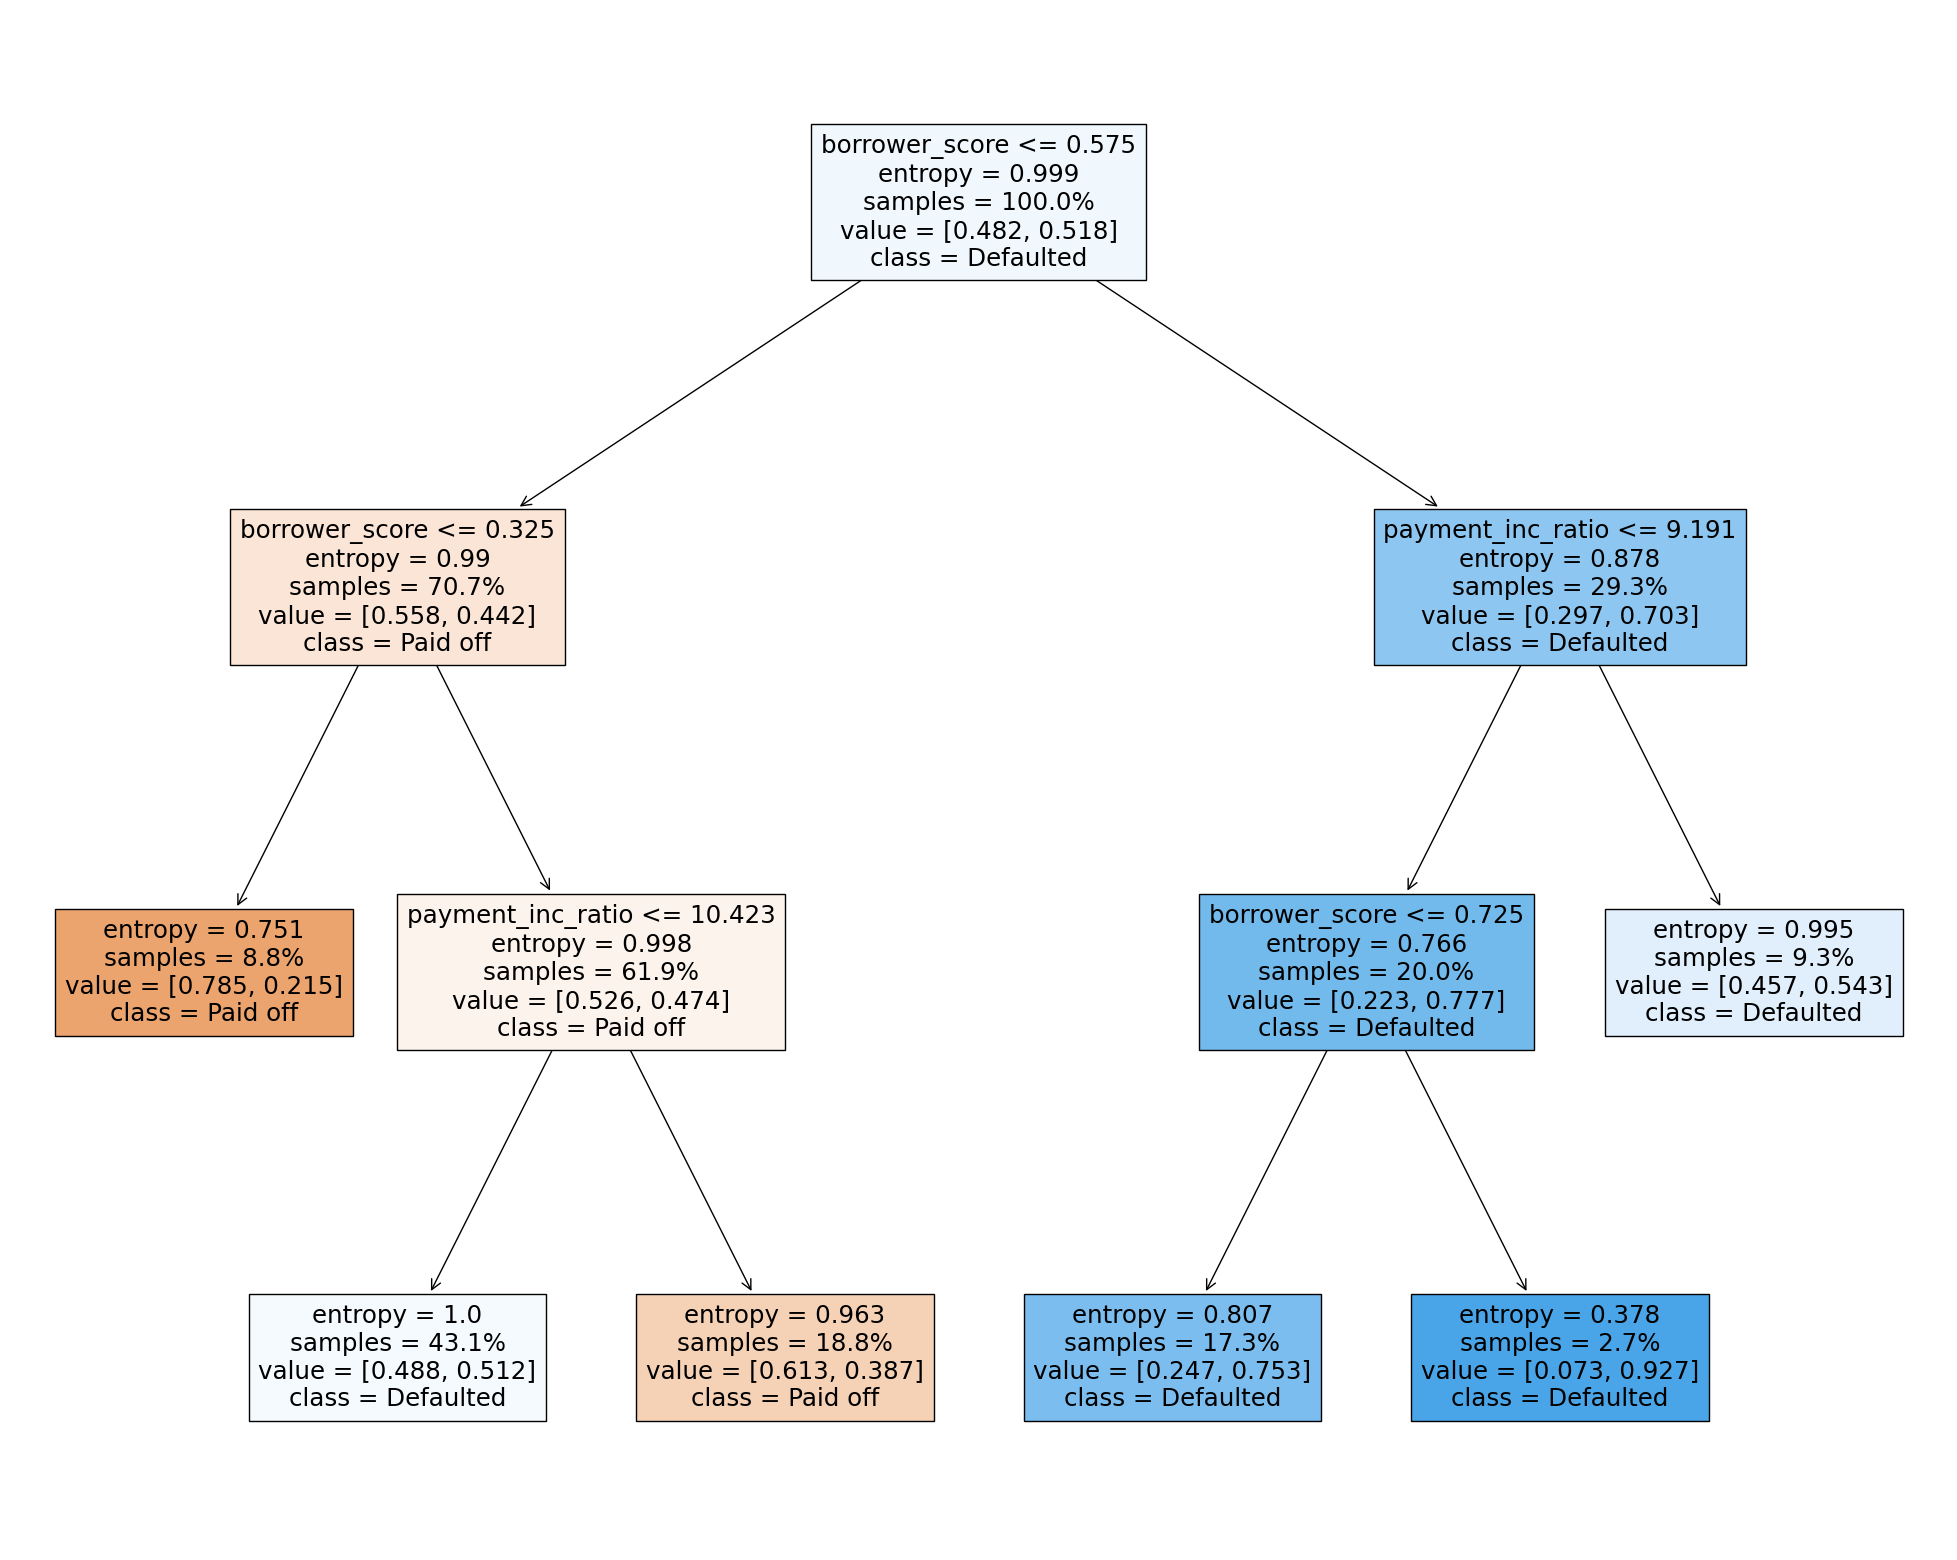

In [9]:
loan3000 = pd.read_csv('data/loan3000.csv')

predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_tree = DecisionTreeClassifier(random_state=1, criterion='entropy',
                                   min_impurity_decrease=0.003)
loan_tree.fit(X, y)

fig = plt.figure(figsize = (25, 20))
plot_tree(
    loan_tree,
    feature_names = X.columns,
    class_names = ["Paid off", "Defaulted"],
    impurity = True,
    proportion = True,
    filled = True);

### The Recursive Partitioning Algorithm
The algorithm to construct a decision tree, called __recursive partitioning__, is straightforward and intuitive. The data is repeatedly partitioned using predictor values that do __the best job of separating the data into relatively homogeneous partitions__. The chart below shows the partitions created for the tree fitted earlier.

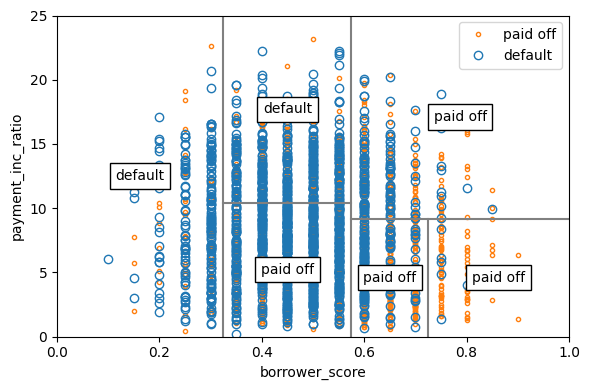

In [10]:
fig, ax = plt.subplots(figsize=(6, 4))

loan3000.loc[loan3000.outcome=='paid off'].plot(
    x='borrower_score', y='payment_inc_ratio', style='.', 
    markerfacecolor='none', markeredgecolor='C1', ax=ax)
loan3000.loc[loan3000.outcome=='default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o', 
    markerfacecolor='none', markeredgecolor='C0', ax=ax)
ax.legend(['paid off', 'default']);
ax.set_xlim(0, 1)
ax.set_ylim(0, 25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')

x0 = 0.575
x1a = 0.325; y1b = 9.191
y2a = 10.423; x2b = 0.725
ax.plot((x0, x0), (0, 25), color='grey')
ax.plot((x1a, x1a), (0, 25), color='grey')
ax.plot((x0, 1), (y1b, y1b), color='grey')
ax.plot((x1a, x0), (y2a, y2a), color='grey')
ax.plot((x2b, x2b), (0, y1b), color='grey')

labels = [('default', (x1a / 2, 25 / 2)),
          ('default', ((x0 + x1a) / 2, (25 + y2a) / 2)),
          ('paid off', ((x0 + x1a) / 2, y2a / 2)),
          ('paid off', ((1 + x0) / 2, (y1b + 25) / 2)),
          ('paid off', ((1 + x2b) / 2, (y1b + 0) / 2)),
          ('paid off', ((x0 + x2b) / 2, (y1b + 0) / 2)),
         ]
for label, (x, y) in labels:
    ax.text(x, y, label, bbox={'facecolor':'white'},
            verticalalignment='center', horizontalalignment='center')

plt.tight_layout()
plt.show()

Suppose we have a response variable $Y$ and a set of $P$ predictor variables $X_j$ for $j = 1,...,P$. For a partition $A$ of records, recursive partitioning will find the best way to partition $A$ into two subpartitions:
1. For each predictor variable $X_j$:
   1. For each value $s_j$ of $X_j$:
       1. Split the records in $A$ with $X_j$ values < $s_j$ as one partition, and the remaining records where $X_j$ >= $s_j$ as another partition.
       2. Measure the homogeneity of classes within each subpartition of $A$.
   2. Select the value of $s_j$ that produces maximum within-partition homogeneity of class.
2. Select the variable $X_j$ and the split value $s_j$ that produces maximum within-partition homogeneity of class.

Now comes the recursive part:
1. Initialize $A$ with the entire data set.
2. Apply the partitioning algorithm to split $A$ into two subpartitions, $A_1$ and $A_2$.
3. Repeat step 2 on subpartitions $A_1$ and $A_2$.
4. The algorithm terminates when no further partition can be made that sufficiently improves the homogeneity of the partitions.

The end result is a partitioning of the data, except in $P$-dimensions, with each partition predicting an outcome of 0 or 1 depending on the majority vote of the response in that partition.

In addition to a binary 0/1 prediction, tree models can produce a probability estimate based on the number of 0s and 1s in the partition. The estimate is simply the sum of 0s and 1s in the partition divided by the number of observations in the partition. The estimated probability can then be converted to a binary decision; for example, set the estimate to 1 if probability > 0.5.

### Measuring Homogeneity or Impurity
Tree models recursively create partitions, $A$, that predict an outcome of $Y$=0 or $Y$=1. You can see from the preceeding algorithm that we need a way to measure homogeneity, also called __class purity__, within a partition. Or equivalently, we need to measure the impurity of a partition. The accuracy of the predictions is the proportion $p$ of misclassified records within thatpartition, which ranges from 0 (perfect) to 0.5 (purely random guessing).

It turns out that accuracy is not a good measure for impurity. Instead, two common measures for impurity are the __Gini impurity__ and __entropy of information__. While these impurity measures apply to classification problems with more than two classes, we focus on the binary case. The Gini impurity for a set of records $A$ is:

$$
I(A) = p(1-p)
$$

The entropy measure is given by:
$$
I(A) = (-p)log_2(p)-(1-p)log_2(1-p)
$$

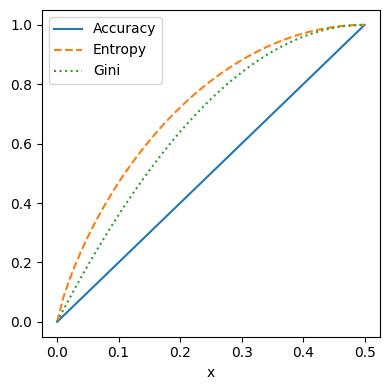

In [11]:
def entropyFunction(x):
    if x == 0: return 0
    return -x * math.log(x, 2) - (1 - x) * math.log(1 - x, 2)

def giniFunction(x):
    return x * (1 - x)

x = np.linspace(0, 0.5, 50)
impure = pd.DataFrame({
    'x': x,
    'Accuracy': 2 * x,
    'Gini': [giniFunction(xi) / giniFunction(.5) for xi in x],
    'Entropy': [entropyFunction(xi) for xi in x],
})

fig, ax = plt.subplots(figsize=(4, 4))

impure.plot(x='x', y='Accuracy', ax=ax, linestyle='solid')
impure.plot(x='x', y='Entropy', ax=ax, linestyle='--')
impure.plot(x='x', y='Gini', ax=ax, linestyle=':')

plt.tight_layout()
plt.show()

The chart above shows that Gini impurity and entropy measures are similar, with entropy giving higher impurity scores for moderate and high accuracy rates.

The impurity metric is used in the splitting algorithm described earlier. For each proposed partition of the data, impurity is measured for each of the partitions that result from the split. A weighted average is then calculated, and whichever partition (at each stage) yields the lowest weighted average is selected.

### Stopping the Gree from Growing
As the tree grows bigger, the splitting rules become more detailed, and the tree gradually shifts from identifying "big" rules that identify real and reliable relationships in the data to "tiny" rules that reflect only noise. We need some way to determine when to stop growing a tree at a stage that will generalize to new data. There are various ways to stop splitting.
1. Avoid splitting a partition if a resulting subpartition is too small, or __if a terminal leaf is too small__. we can control this using the parameters "__min_samples_split__" and "__min_samples_leaf__".
2. Don't split a partition __if the new partition does not "significantly" reduce the impurity__. We can control this using the parameter "__min_impurity_decrease__", which limits splitting based on a weihted impurity decrease value. Here, smaller values will lead to more complex trees.

These methods involve arbitrary rules and can be useful for exploratory work, but we can't easily determine optimum values (i.e., values that maximize predictive accuracy with new data). We need to combine cross-validation with either systematically changing the model parameters or modifying the tree through pruning.

#### Controlling tree complexity
Neither the complexity parameter nor pruning is available in scikit-learn's decision tree implementation. The solution is to use grid search over combinations of different parameter values. For example, we can vary "max_depth" in the range 5 to 30 and "min_samples_split" between 20 and 100. 

### Predicting a Continuous Value
Predicting a continuous value with a tree follows the same logic and procedure, __except that impurity is measured by squared deviations from the mean (squared errors) in each subpartition__, and __predictive performance is judged by the square root of the mean squared error (RMSE) in each partition__.

### How Trees Are Used
One of the big obstacles faced by predictive modelers in organizations is the perceived "black box" nature of the methods they use, which gives rise to opposition from other elements of the organization. In this regard, the tree model has two appealing aspects:
- Tree models provide a visual tool for exploring the data, to gain an idea of what variables are important and how they relate to one another. Trees can capture nonlinear relationships among predictor variables.
- Tree models provide a set of rules that can be effectively communicated to non-specialists, either for implementation or to "sell" a data mining project.

When it comes to prediction, however, harnessing the results from multiple trees is typically more powerful than using just a single tree. In particular, the random forest and boosted tree algorithms almost always provide superior predictive accuracy and performance, but the aforementioned advantages of a single tree are lost.

## Bagging and Random Forest
- Ensemble models improve model accuracy __by combining the results from many models__.
- Bagging is a particular type of ensemble model based on fitting many models to __bootstrapped samples__ of the data and averaging the models.
- Random Forest is a special type of bagging applied to decision trees. In addition to resampling the data, the ranom forest algorithm __samples the predictor variables when splitting the trees__.
- A useful output from the random forest is a measure of __variable importance__ that ranks the predictors in terms of their contribution to model accuracy.
- The random forest has a set of hyperparameters that should be tuned using cross-validation to avoid overfitting.

The ensemble approch has been applied to and across many different modeling methods. The simple version of ensembles is as follows:
1. Develop a predictive model and record the predictions for a given data set.
2. Repeat for multiple models on the same data.
3. For each record to be predicted, take an average (or a weighted average, or a majority vote) of the predictions.

### Bagging
Bagging, whcih stands for "__bootstrap aggregating__," is like the basic algorithm for ensembles, except that, instead of fitting the various models to the same data, each new model is fitted to __a bootstrap resample__. Here is the algorithm presented more formally:
1. Initialize $M$, the number of models to be fit, and $n$, the number of records to choose ($n$ < $N$). Set the iteration $m$=1.
2. Take a bootstrap resample (i.e., with replacement) of $n$ records from the training data to form a subsample $Y_m$ and $X_m$ (the bag).
3. Train a model using $Y_m$ and $X_m$ to create a set of decision rules $\hat{f_m}(X)$.
4. Increment the model counter m = $m$+1. If $m <= M$, go to step 2.

### Random Forest
The __random forest__ is based on applying bagging to decision trees, with one important extension: in addition to sampling the records, __the algorithm also samples the variables__. In traditional decision trees, to determine how to create a subpartition of a partition $A$, the algorithm makes the choice of variable and split point by minimizing a criterion such as Gini impurity. With random forests, at each stage of the algorithm, the choice of variable is limited to a __random subset of variables__. Compared to the basic tree algorithm, the random forest algorithm adds two more steps: the bagging discussed earlier, and the bootstrap sampling of variables at each split:
1. Take a bootstrap (with replacement) subsample from the records.
2. For the first split, sample $p < P$ variables at random without replacement.
3. For each of the sampled variables $X_j,_1, X_j,_2,..., X_j,_p$, apply the splitting algorithm:
   1. For each value $s_j,_k$ of $X_j,_k$:
      1. Split the records in partition $A$, with $X_j,_k$ < $s_j,_k$ as one partition and the remaining records where $s_j,_k$ >= $X_j,_k$ as another partition.
      2. Measure the homogeneity of classes within each subpartition of $A$.
   2. Select the value of $s_j,_k$ that produces maximum within-partition homogeneity of class.
4. Select the value of $X_j,_k$ and the split value $s_j,_k$ that produces maximum within-partition homogeneity of class.
5. Proceed to the next split and repeat the previous steps, starting with step 2.
6. Continue with additional splits, following the same procedure until the tree is grown.
7. Go back to step 1, take another bootstrap subsample, and start the process over agian.

How many variables to sample at each step? A rule of thumb is __to choose $\sqrt{P}$ where $P$ is the number of predictor variables__.

In [12]:
predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

rf = RandomForestClassifier(n_estimators=500, random_state=1, 
                            oob_score=True)
rf.fit(X, y)

RandomForestClassifier(n_estimators=500, oob_score=True, random_state=1)

By default, __500__ trees are trained. Since there are only two variables in the predictor set, the algorithm randomly selects the variable on which to split at each stage (i.e., a bootstrap subsample of size 1). 

The __out-of-bag (OOB)__ estimate of error is __the error rate for the trained models, applied to the data left out of the training set for that tree__. Using the output from the model, the OOB error can be plotted versus the number of trees in the random forest. In python, there is no easy way to get OOB estimates as a function of number of trees in the random forest. We can train a sequence of classifiers with an increasing number of trees and keep track of the oob_score_ values. This method is, however, not efficient:

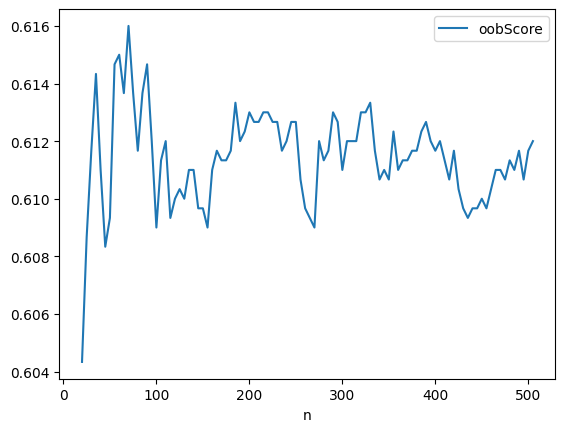

In [13]:
n_estimator = list(range(20, 510, 5))
oobScores = []
for n in n_estimator:
    rf = RandomForestClassifier(n_estimators=n, 
                                criterion='entropy', max_depth=5,
                                random_state=42, oob_score=True)
    rf.fit(X, y)
    oobScores.append(rf.oob_score_)

pd.DataFrame({
    'n': n_estimator, 
    'oobScore': oobScores
}).plot(x='n', y='oobScore')
plt.show()

The predicted values can be obtained and plotted as well:

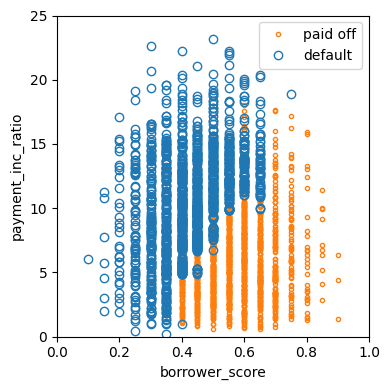

In [14]:
predictions = X.copy()
predictions['prediction'] = rf.predict(X)
predictions.head()

fig, ax = plt.subplots(figsize=(4, 4))

predictions.loc[predictions.prediction=='paid off'].plot(
    x='borrower_score', y='payment_inc_ratio', style='.',
    markerfacecolor='none', markeredgecolor='C1', ax=ax)
predictions.loc[predictions.prediction=='default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o',
    markerfacecolor='none', markeredgecolor='C0', ax=ax)
ax.legend(['paid off', 'default']);
ax.set_xlim(0, 1)
ax.set_ylim(0, 25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')

plt.tight_layout()
plt.show()

The random forest method is a "black box" method. It produces more accurate predictions than a simple tree, but the simple tree's intuitive decision rules are lots. The random forest predictions are also somewhat noisy: note that some borrowers with a very high score, indicatinghigh creditworthiness, still end up with a prediction of default. This is a result of some unusual records in the data and demonstrates the dange of overfitting by the randome forest.

### Variable Importance
The power of the  random forest algorithm shows itself when you build predictive models for data with many features and records. It has the ability to __automatically determine which predictors are important and discover complex relationships between predictors corresponding to interaction terms__. For example, fit a model to the loan default data with all columns included:

In [15]:
predictors = ['loan_amnt', 'term', 'annual_inc', 'dti', 
              'payment_inc_ratio', 'revol_bal', 'revol_util', 
              'purpose', 'delinq_2yrs_zero', 'pub_rec_zero', 
              'open_acc', 'grade', 'emp_length', 'purpose_', 
              'home_', 'emp_len_', 'borrower_score']
outcome = 'outcome'

X = pd.get_dummies(loan_data[predictors], drop_first=True, dtype=int)
y = loan_data[outcome]

rf_all = RandomForestClassifier(n_estimators=500, random_state=1)
rf_all.fit(X, y)

RandomForestClassifier(n_estimators=500, random_state=1)

In [16]:
importances = rf_all.feature_importances_
importances

The "__Gini decrease__" is available as the "feature_importance_" property of the fitted classifier. __Accuracy decrease__, however, is not available out of the box for Python. We can calculate it (scores) using the following code:

In [17]:
rf_all_entropy = RandomForestClassifier(n_estimators=500, random_state=1,
                                        criterion='entropy')
print(rf_all_entropy.fit(X, y))

rf = RandomForestClassifier(n_estimators=500)
scores = defaultdict(list)
 
# crossvalidate the scores on a number of different random splits of the data
for _ in range(3):
    train_X, valid_X, train_y, valid_y = train_test_split(X, y, 
                                                          test_size=0.3)
    rf.fit(train_X, train_y)
    acc = metrics.accuracy_score(valid_y, rf.predict(valid_X))
    for column in X.columns:
        X_t = valid_X.copy()
        X_t[column] = np.random.permutation(X_t[column].values)
        shuff_acc = metrics.accuracy_score(valid_y, rf.predict(X_t))
        scores[column].append((acc-shuff_acc)/acc)
print('Features sorted by their score:')
print(sorted([(round(np.mean(score), 4), feat) for
              feat, score in scores.items()], reverse=True))

RandomForestClassifier(criterion='entropy', n_estimators=500, random_state=1)
Features sorted by their score:
[(0.0756, 'borrower_score'), (0.0362, 'grade'), (0.0296, 'term_60 months'), (0.0137, 'annual_inc'), (0.01, 'payment_inc_ratio'), (0.0031, 'dti'), (0.0025, 'purpose_small_business'), (0.0024, 'revol_bal'), (0.0022, 'purpose__small_business'), (0.0021, 'revol_util'), (0.0012, 'open_acc'), (0.001, 'home__OWN'), (0.0005, 'purpose_wedding'), (0.0005, 'purpose_moving'), (0.0004, 'purpose_credit_card'), (0.0004, 'home__RENT'), (0.0004, 'delinq_2yrs_zero'), (0.0, 'purpose_major_purchase'), (0.0, 'purpose_house'), (-0.0, 'pub_rec_zero'), (-0.0001, 'purpose_vacation'), (-0.0001, 'purpose_medical'), (-0.0001, 'purpose__medical'), (-0.0001, 'emp_len__ > 1 Year'), (-0.0002, 'purpose__major_purchase'), (-0.0004, 'purpose_other'), (-0.0004, 'purpose__home_improvement'), (-0.001, 'purpose_home_improvement'), (-0.001, 'purpose_debt_consolidation'), (-0.001, 'purpose__other'), (-0.0011, 'purpose

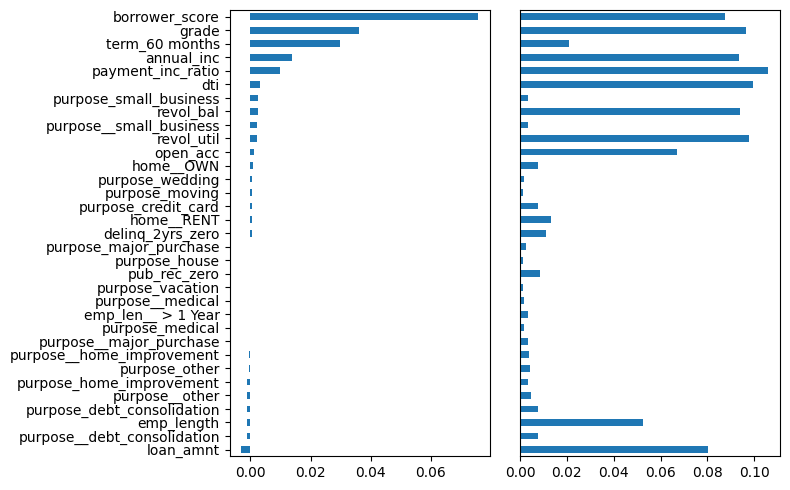

In [18]:
df = pd.DataFrame({
    'feature': X.columns, 
    'Accuracy decrease': [np.mean(scores[column]) for column in 
                         X.columns],
    'Gini decrease': rf_all.feature_importances_, 
    'Entropy decrease': rf_all_entropy.feature_importances_,
})
df = df.sort_values('Accuracy decrease')

fig, axes = plt.subplots(ncols=2, figsize=(8, 5))
ax = df.plot(kind='barh', x='feature', y='Accuracy decrease', 
             legend=False, ax=axes[0])
ax.set_ylabel('')

ax = df.plot(kind='barh', x='feature', y='Gini decrease', 
             legend=False, ax=axes[1])
ax.set_ylabel('')
ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

There are two ways to measure variable importance:
- By the decrease in accuracy of the model if the values of a variable are randomly permuted (type=1). Randomly permuting the values has the effect of removing all predictive power for that variable. Theaccuracy is computed from __the out-of-bag data__ (so this measure is effectively a cross-validated estimate).
- By the mean decrease in the Gini impurity score for all of the nodes that were split on a variable (type = 2). This measures how much including that variable improves the purity of the nodes. This measure is based on __the training set__ and is therefore __less reliable than a measure calculated on out-of-bag data__.

The left and right panels of the charts above show variable importance according to the decrease in accuracy and in Gini impurity, respectivey. The variables in both panels are ranked by the decrease in accuracy. The variable importance scores produced by these two measures are quite different. 

Since the accuracy decrease is a more reliable metric, why should we use the Gini impurity decrease measure? By default, random forest computes only this Gini impurity: __Gini impurity is a byproduct of the algorithm, whereas model accuracy by variable requires extra computations__ (randomly permuting the data and predicting this data). In cases where computational complexity is important, such as in a production setting where thousands of models are being fit, it may not be worth the extra computational effort. In addition, the Gini decrease sheds light on which variables the random forest is using to make its splitting rules (recall that this information, readily visible in a simple tree, is effectively lost in a random forest).

### Hyperparameters
The random forest can be considered a black-box algorithm with knobs to adjust how the box works. These knobs are called hyperparameters, which are parameters that you need to set before fitting a model; they are not optimized as part of the training process. While traditional statistical models require choices (e.g., the choice of predictors to use in a regression model), the hyperparameters for random forest are more critical, especially to avoid overfitting. In particular, the __two most important hyperparameters for the random forest__ are:
- __min_samples_leaf__: The minimum size for terminal nodes (leaves in the tree). The default is 1 for both classification and regression.
- __max_leaf_nodes__: The maximum number of nodes in each decision tree. By default, there is no limit and the largest tree will be fit subject to the constraints of node sizes. Note that in python, you specify the maximum number of terminal nodes. The two parameters are related:
  - maxnodes = 2 max_leaf_nodes - 1
 
It may be tempting to ignore these parameters and simply go with the default values. However, using the defaults may lead to overfitting when you apply the random forest to noisy data. __When you increase "min_samples_leaf" or set "max_leaf_nodes," the algorithm will fit smaller trees and is less likely to create spurious predictive rules__. Cross-validation can be used to test the effects of setting different values for hyperparameters.

## Boosting
- Boosting is a class of ensemble models based on fitting a sequence of models, __with more weight given to records with large errors in successive rounds__.
- __Stochastic gradient boosting__ is the most general type of boosting and offers the best performance. The most common from of stochastic gradient boosting uses tree models.
- __XGBoost__ is a popular and computationally efficient software package for stochastic gradient boosting; it is available in all common languages used in data science.
- Boosting is prone to overfitting the data, and the hyperparameters need to be tuned to avoid this.
- Regularization is one way to avoid overfitting by including a penalty term on the number of parameters (e.g., tree size) in a model.
- Cross-validation is especially important for boosting due to the large number of hyperparameters that need to be set.

In linear regression models, the residuals are often examined to see if the fit can be improved. Boosting takes this concept much further and fits a series of models, in which __each successive model seeks to minimize the error of the previous model__. Several variants of the algorithm are commonly used: Adaboost, gradient boosting, and stochastic gradient boosting. The latter, stochastic gradient boosting, is the most general and widely used. Indeed, with the right choice of parameters, the algorithm can emulate the random forest.

### The Boosting Algorithm
There are various boosting algorithms, and the basic idea behind all of them is essentially the same. The easiest to understand is AdaBoost:
1. Initialize $M$, the maximum number of models to be fit, and set the iteration counter $m$ = 1. Initialize the observation weights $w_i = \frac{1}{N} \text{ for } i = 1,2,...,N$. Initialize the ensemble model $\hat{F} = 0$.
2. Using the observation weights $w_1, w_2,...,w_N$, train a model $\hat{f}$ that minimizes the weighted error $e_m$ defined by summing the weights for the misclassified observations.
3. Add the model to the ensemble: $\hat{F_m} = \hat{F_{m-1}} + \alpha_m\hat{f_m}$ where $\alpha_m = \frac{log(1-e_m)}{e_m}$.
4. Update the weights $w_1, w_2,...,w_N$ so that the weights are increased for the observations that were misclassified. The size of the increase depends on $\alpha_m$, with larger values of $\alpha_m$ leading to bigger weights.
5. Increment the model counter $m = m + 1$. If $m <= M$, go to step 2.

The boosted estimate is given by:
$$
\hat{F} =\alpha_1\hat{f_1} + \alpha_2\hat{f_2} + ... + \alpha_M\hat{f_M}
$$

__By increasing the weihts for the observations that were misclassified, the algorithm forces the models to train more heavily on the data for which it performed poorly__. The factor $\alpha_m$ ensures that models with lower error have a bigger weight.

Gradient boosting is similar to Adaboost but casts the problem as an optimization of a cost function. Instead of adjusting weights, __gradient boosting fits models to a pseudo-residuals__, which has the effect of training more heavily on the larger residuals. In the spirit of random forest, stochastic gradient boosting adds randomness to the algorithm by sampling observations and predictor variables at each stage.

### XGBoost
The most widely used public domain software for boosting is XGBoost. The method has many parameters that can, and should, be adjusted. __Two very important parameters are "subsample," which controls the fraction of observations that should be sampled at each iteration, and "eta," a shrinkage factor applied to $\alpha_m$ in the boosting algorithm__. Using "subsample" makes boosting act like the random forest except that the sampling is done __without replacement__. The shrinkage parameter "eta" is helpful to prevent overfitting __by reducing the change in the weights__ (a smaller change in the weights means the algorithm is less likely to overfit to the training set). In python, to be consistent with other scikit-learn methods, some parameters were renamed. For example, "eta" is renamed to "learning_rate;" using "eta" will not fail, but it will not have the desired effect:

In [19]:
predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = pd.Series([1 if o == 'default' else 0 for o in loan3000[outcome]])

xgb = XGBClassifier(objective='binary:logistic', subsample=.63, 
                    eval_metric='error')
print(xgb.fit(X, y))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


In [20]:
xgb_df = X.copy()
xgb_df['prediction'] = ['default' if p == 1 else 'paid off' for p in xgb.predict(X)]
xgb_df['prob_default'] = xgb.predict_proba(X)[:, 0]
print(xgb_df.head())

   borrower_score  payment_inc_ratio prediction  prob_default
0            0.40            5.11135   paid off      0.586677
1            0.40            5.43165    default      0.307408
2            0.70            9.23003    default      0.337050
3            0.40            2.33482   paid off      0.861774
4            0.45           12.10320    default      0.056794


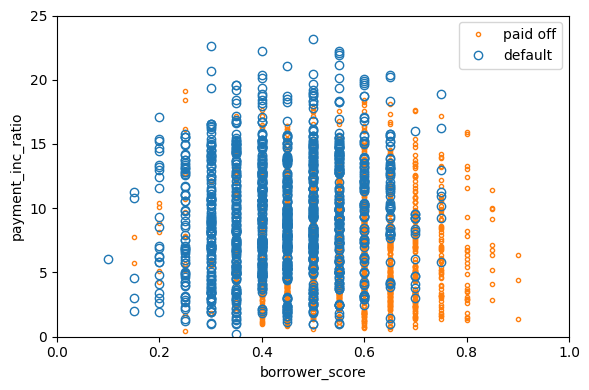

In [21]:
fig, ax = plt.subplots(figsize=(6, 4))

xgb_df.loc[xgb_df.prediction=='paid off'].plot(
    x='borrower_score', y='payment_inc_ratio', style='.', 
    markerfacecolor='none', markeredgecolor='C1', ax=ax)
xgb_df.loc[xgb_df.prediction=='default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o', 
    markerfacecolor='none', markeredgecolor='C0', ax=ax)
ax.legend(['paid off', 'default']);
ax.set_xlim(0, 1)
ax.set_ylim(0, 25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')

plt.tight_layout()
plt.show()

Qualitatively, this is similar to the predictions from the random forest. The predictions are somewhat noisy in that some borrows with a very high borrower score still end up with a prediction of default.

### Regularization: Avoid Overfitting
Blind application of xgboost can lead to unstable models as a result of overfitting to the training data. The problem with overfitting is twofold:
- The accuracy of the model on new data not in the training set will be degraded.
- The predictions from the model are highly variable, leading to unstable results.

Any modeling technique is potentially prone to overfitting. However, for most statistical techniques, overfitting can be avoided by a judicious selection of predictor variables. Even the random forest generally produces a reasonable model without tuning the parameters.

This, however, is not the case for xgboost. Fit xgboost to the loan data for a training set with all of the variables included in the model.

In [22]:
predictors = ['loan_amnt', 'term', 'annual_inc', 'dti', 
              'payment_inc_ratio', 'revol_bal', 'revol_util', 
              'purpose', 'delinq_2yrs_zero', 'pub_rec_zero', 
              'open_acc', 'grade', 'emp_length', 'purpose_', 
              'home_', 'emp_len_', 'borrower_score']
outcome = 'outcome'

X = pd.get_dummies(loan_data[predictors], drop_first=True, dtype=int)
y = pd.Series([1 if o == 'default' else 0 for o in loan_data[outcome]])

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=10000)

xgb_default = XGBClassifier(objective='binary:logistic', n_estimators=250, max_depth=6,
                            reg_lambda=0, learning_rate=0.3, subsample=1,
                            eval_metric='error')
xgb_default.fit(train_X, train_y)

pred_default = xgb_default.predict_proba(train_X)[:, 1]
error_default = abs(train_y - pred_default) > 0.5
print('default (train): ', np.mean(error_default))

pred_default = xgb_default.predict_proba(valid_X)[:, 1]
error_default = abs(valid_y - pred_default) > 0.5
print('default: ', np.mean(error_default))

default (train):  0.10129590855073284
default:  0.3582


The test set cointains 10,000 randomly sampled records from the full data, and the training set consists of the remaining records. Boosting leads to an error rate of only 10% for the training set. The test set, however, has a much higher error rate of 36%. This is a result of overfitting: while boosting can explin the variability in the training set very well, the prediction rules do not apply to new data.

Boosting provides several parameters to avoid overfitting, including the parameters "eta" and "subsample." Another approach is __regularization__, a technique that modifies the cost function in order __to penalize the complexity of the model__. Decision trees are fit by mnimizing cost criteria such as Gini's impurity score. In xgboost, it is possible to modify the cost function by adding a term that measures the complexity of the model. 

There are two parameters in xgboost to regularize the model: "__alpha__" and "__lambda__," which correspond to __Manhattan distance__ (L1-regularization) and __squared Euclidean distance__ (L2-regularization), respectively. Increasing these parameters will penalize more complex models and __reduce the size of the trees that are fit__. For example, see what happens if we set lambda to 1,000: 

In [23]:
xgb_penalty = XGBClassifier(objective='binary:logistic', n_estimators=250, max_depth=6,
                            reg_lambda=1000, learning_rate=0.1, subsample=0.63,
                            eval_metric='error')
print(xgb_penalty.fit(train_X, train_y))

pred_penalty = xgb_penalty.predict_proba(train_X)[:, 1]
error_penalty = abs(train_y - pred_penalty) > 0.5
print('default (train): ', np.mean(error_penalty))

pred_penalty = xgb_penalty.predict_proba(valid_X)[:, 1]
error_penalty = abs(valid_y - pred_penalty) > 0.5
print('penalty: ', np.mean(error_penalty))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
default (train):  0.3136211872559561
penalty:  0.3268


Now the training error is only slightly lower than the error on the test set.

We can call the "__ntree_limit__" arguement, that forces only the first $i$ trees to be used in the prediction. This lets us directly compare the in-sample versus out-of-sample error rates as more models are included:

In [24]:
results = []
for ntree_limit in range(1, 250):
    iteration_range = [1, ntree_limit + 1]
    train_default = xgb_default.predict_proba(train_X, iteration_range=iteration_range)[:, 1]
    train_penalty = xgb_penalty.predict_proba(train_X, iteration_range=iteration_range)[:, 1]
    pred_default = xgb_default.predict_proba(valid_X, iteration_range=iteration_range)[:, 1]
    pred_penalty = xgb_penalty.predict_proba(valid_X, iteration_range=iteration_range)[:, 1]
    results.append({
        'iterations': ntree_limit,
        'default train': np.mean(abs(train_y - train_default) > 0.5),
        'penalty train': np.mean(abs(train_y - train_penalty) > 0.5),
        'default test': np.mean(abs(valid_y - pred_default) > 0.5),
        'penalty test': np.mean(abs(valid_y - pred_penalty) > 0.5),
    })

results = pd.DataFrame(results)
print(results.head())

   iterations  default train  penalty train  default test  penalty test
0           1       0.341888       0.344887        0.3591        0.3554
1           2       0.329127       0.338181        0.3500        0.3480
2           3       0.325392       0.336965        0.3440        0.3496
3           4       0.320525       0.337049        0.3410        0.3511
4           5       0.317300       0.339087        0.3401        0.3507


We can use the pandas plot method to create the line graph. The axis returned from the first plot allows us to overlay additional lines onto the same graph. This is a pattern that many of Python's graph packages support:

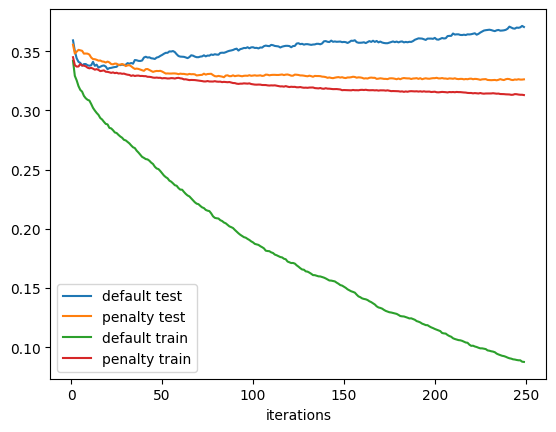

In [25]:
ax = results.plot(x='iterations', y='default test')
results.plot(x='iterations', y='penalty test', ax=ax)
results.plot(x='iterations', y='default train', ax=ax)
results.plot(x='iterations', y='penalty train', ax=ax)
plt.show()

The result shows how the default model steadily improves the accuracy for the training set but actually gets worse for the test set. The penalized model does not exhibit this behavior.

### Ridge Regression and the Lasso
Leaset squares regression minimizes the residual sum of squares (RSS). __Ridge regression__ minimizes the sum of squared residuals plus a penalty term that is a function of the number and size of the coefficients: 

$$
\sum_{i=1}^{n} (Y_i - \hat{b_0} - \hat{b_1}X_i - ... \hat{b}X_p)^2 + \lambda(\hat{b}_1^2  +...+ \hat{b}_p^2)
$$

The value of lambda determines how much the coefficients are penalized; larger values produce models that are less likely to overfit the data. The __Lasso__ is similar, except that it uses Manhattan distance instead of Euclidean distance as a penalty term:

$$
\sum_{i=1}^{n} (Y_i - \hat{b_0} - \hat{b_1}X_i - ... \hat{b}X_p)^2 + \alpha(|\hat{b}_1|  +...+ |\hat{b}_p|)
$$

Using Euclidean distance is also known as L2 regularization, and using Manhattan distance as L1 regression. The xgboost parameters reg_lambda and reg_alpha are acting in a similar manner.

### Hyperparameters and Cross-Validation
xgboost has a daunting array of hyperparameters. The specific choice can dramatically change the model fit. Given a huge combination of hyperparameters to choose from, how should we be guided in our choise? A standard solution to this problem is to use cross-validation.

In [26]:
idx = np.random.choice(range(5), size=len(X), replace=True)
error = []
for eta, max_depth in product([0.1, 0.5, 0.9], [3, 6, 9]): #1
    xgb = XGBClassifier(objective='binary:logistic', n_estimators=250, 
                        max_depth=max_depth, learning_rate=eta,
                        eval_metric='error')
    cv_error = []
    for k in range(5):
        fold_idx = idx == k
        train_X = X.loc[~fold_idx]; train_y = y[~fold_idx]
        valid_X = X.loc[fold_idx]; valid_y = y[fold_idx]

        xgb.fit(train_X, train_y)
        pred = xgb.predict_proba(valid_X)[:, 1]
        cv_error.append(np.mean(abs(valid_y - pred) > 0.5))
    error.append({
        'eta': eta,
        'max_depth': max_depth,
        'avg_error': np.mean(cv_error)
    })
    print(error[-1])
errors = pd.DataFrame(error)
print(errors)

#1
#We use the function "itertools.product" from the Python standard library to create all possible combinations of the two hyperparameters.

{'eta': 0.1, 'max_depth': 3, 'avg_error': 0.3276255569102701}
{'eta': 0.1, 'max_depth': 6, 'avg_error': 0.33605498688649604}
{'eta': 0.1, 'max_depth': 9, 'avg_error': 0.34589316359353656}
{'eta': 0.5, 'max_depth': 3, 'avg_error': 0.33675812947084294}
{'eta': 0.5, 'max_depth': 6, 'avg_error': 0.3684337902194876}
{'eta': 0.5, 'max_depth': 9, 'avg_error': 0.3742316280397226}
{'eta': 0.9, 'max_depth': 3, 'avg_error': 0.3502652204431893}
{'eta': 0.9, 'max_depth': 6, 'avg_error': 0.3891476568923311}
{'eta': 0.9, 'max_depth': 9, 'avg_error': 0.3817039044258914}
   eta  max_depth  avg_error
0  0.1          3   0.327626
1  0.1          6   0.336055
2  0.1          9   0.345893
3  0.5          3   0.336758
4  0.5          6   0.368434
5  0.5          9   0.374232
6  0.9          3   0.350265
7  0.9          6   0.389148
8  0.9          9   0.381704


Since we are fitting 45 total models, this can take a while. The errors are stored as a matrix with the models along the rows and folds along the columns. Cross Validation suggests that using shallower trees with a smaller value of eta/learning_rate yields more accurate results. Since these models are also more stable, the best parameters to use are eta = 0.1, and max_depth = 3.

### XGBoost Hyperparameters
The hyperparameters for xgboost are primarily used to balance overfitting with the accuracy and computational complexity. For a complete discussion of the parameters, refer to the xgboost documentation. 

- __eta/learning rate__:
  - The shrinkage factor between 0 and 1 applied to $\alpha$ in the boosting algorithm. The default is 0.1 in python.
-__nrounds/n_estimators__:
  - The number of boosting rounds. If eta is set to a small value, it is important to increase the number of rounds since the algorithm learns more slowly. As long as some parameters are included to prevent overfitting, having more rounds doesn't hurt.
- __max_depth__:
  - The maximum depth of the tree. In contrast to the random forest, which fits very deep trees, boosting usually fits shallow trees. This has the advantage of avoiding spurious complex interactions in the model that can arise from noisy data. In python, the default is 3.
- __subsample and colsample_bytree__:
  - Fraction of th records to sample without replacement and the fraction of predictors to sample for use in fitting the trees. These parameters, which are similar to those in random forests, help avoid overfitting. The default is 1.0.
- __lambda/reg_lambda__ and __alpha/reg_alpha__:
  - The regularization parameters to help control overfitting. Default values for python are reg_lambda = 1 and reg_alpha = 0.